# Exercise
**file name:** clustering_anomaly_detection.py or clustering_anomaly_detection.ipynb

In [2]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from acquire import wrangle_logs_for_clustering

%matplotlib inline

In [3]:
df = wrangle_logs_for_clustering()

In [4]:
id_counts = df.groupby(['user_id'])['ds','cohort','destination'].nunique()
cohort_counts = df.groupby(['cohort'])['destination','user_id','ds'].nunique()
first_access = df.groupby(['user_id'])['ds'].min()
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().groupby('first_access_date').count()

In [5]:
page_views = df.groupby(['user_id'])['destination'].agg(['count','nunique'])
page_views

,count,nunique
user_id,,
1,5437,819
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
646,41,23
647,10,6
648,488,130


In [6]:
scaler = MinMaxScaler().fit(page_views)
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[0.49132321, 1.        ],
       [0.13919017, 0.18337408],
       [0.14108821, 0.20537897],
       [0.06245481, 0.17359413],
       [0.15365148, 0.2396088 ],
       [0.1271692 , 0.27383863],
       [0.16287057, 0.20782396],
       [0.04356471, 0.10880196],
       [0.0527838 , 0.17726161],
       [0.08152567, 0.17359413]])

In [7]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(page_views_scaled_array)

In [8]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [9]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns)
scaled_df

,scaled_count,scaled_nunique
0,0.491323,1.000000
1,0.139190,0.183374
2,0.141088,0.205379
3,0.062455,0.173594
4,0.153651,0.239609
...,...,...
645,0.003615,0.026895
646,0.000813,0.006112
647,0.044017,0.157702
648,0.000000,0.000000


In [10]:
# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, on=page_views.index)
page_views

,key_0,count,nunique,scaled_count,scaled_nunique
0,1,5437,819,0.491323,1.000000
1,2,1541,151,0.139190,0.183374
2,3,1562,169,0.141088,0.205379
3,4,692,143,0.062455,0.173594
4,5,1701,197,0.153651,0.239609
...,...,...,...,...,...
645,646,41,23,0.003615,0.026895
646,647,10,6,0.000813,0.006112
647,648,488,130,0.044017,0.157702
648,649,1,1,0.000000,0.000000


In [11]:
page_views = page_views.drop(columns=['key_0'])
page_views.head()

,count,nunique,scaled_count,scaled_nunique
0,5437,819,0.491323,1.000000
1,1541,151,0.139190,0.183374
2,1562,169,0.141088,0.205379
3,692,143,0.062455,0.173594
4,1701,197,0.153651,0.239609


In [12]:
labels = dbsc.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [13]:
page_views['labels'] = labels
page_views.labels.value_counts()

 0    642
-1      8
Name: labels, dtype: int64

In [14]:
page_views[page_views.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
0,5437,819,0.491323,1.000000,-1
10,11065,698,1.000000,0.852078,-1
52,9534,303,0.861623,0.369193,-1
63,10784,373,0.974602,0.454768,-1
247,2815,456,0.254338,0.556235,-1
313,4695,181,0.424259,0.220049,-1
343,5370,215,0.485268,0.261614,-1
403,1668,352,0.150669,0.429095,-1


In [15]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count     nunique  scaled_count  scaled_nunique      labels
count    650.000000  650.000000    650.000000      650.000000  650.000000
mean     836.301538  116.961538      0.075497        0.141762   -0.012308
std      984.091476   76.488698      0.088945        0.093507    0.110340
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      178.000000   58.000000      0.015998        0.069682    0.000000
50%      677.500000  137.500000      0.061144        0.166870    0.000000
75%     1159.000000  159.000000      0.104664        0.193154    0.000000
max    11065.000000  819.000000      1.000000        1.000000    0.000000
-------------
Inliers
            count     nunique  scaled_count  scaled_nunique  labels
count   642.00000  642.000000    642.000000      642.000000   642.0
mean    766.71028  113.127726      0.069207        0.137075     0.0
std     666.74461   64.576135      0.060263        0.078944     0.0
min       1.00000    1.000000

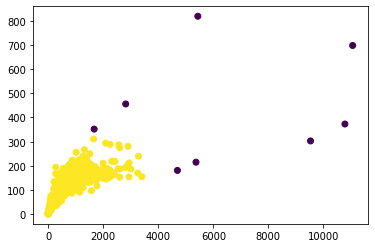

In [16]:
plt.scatter(page_views['count'], page_views['nunique'], c=page_views.labels)
plt.show()

# Ideas:
- Use DBSCAN to detect anomalies in curriculumn access.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 5 columns):
destination    543596 non-null object
user_id        543596 non-null int64
cohort         543596 non-null float64
ip_address     543596 non-null object
ds             543596 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 20.7+ MB


In [18]:
cohort_by_date = df.groupby(['ds'])['cohort', 'destination', 'user_id'].nunique()


In [19]:
cohort_by_date.head()

,cohort,destination,user_id
ds,,,
2018-01-26 09:55:03,1,1,1
2018-01-26 09:56:02,1,1,1
2018-01-26 09:56:05,1,1,1
2018-01-26 09:56:06,1,1,1
2018-01-26 09:56:24,1,1,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 5 columns):
destination    543596 non-null object
user_id        543596 non-null int64
cohort         543596 non-null float64
ip_address     543596 non-null object
ds             543596 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 20.7+ MB


In [21]:
#steps 
# 1 select variables to cluster
cluster = df[['user_id', 'cohort']]

In [22]:
# 2 convert to array & dtype float
clust_array = cluster.values.astype('float32', copy=False)

In [23]:
# 3 scale to standard normal
clust_scale = MinMaxScaler().fit(clust_array)
clust_array = clust_scale.transform(clust_array)

In [ ]:
# 4 create DBSCAN object and fit
dbsc = DBSCAN(eps = .75, min_samples = 13).fit(clust_array)

In [ ]:
# 5 extract labels
labels = dbsc.labels_

In [ ]:
# 6 add labels back to original dataframe:
df['labels'] = labels

In [ ]:
# 7 explore
df.labels.value_counts()

In [ ]:
sns.scatterplot(df.user_id, df.cohort, hue=df.labels)

- Use DBSCAN to detect anomalies in other products from the customers dataset.

- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).